In [12]:
# Importing standard libraries
import os
import warnings

# Importing third-party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from scipy.stats import skew, kurtosis, ttest_ind
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix,
    mean_squared_error,
    mean_squared_log_error,
    r2_score,
    classification_report,
    accuracy_score,
    roc_auc_score
)
import joblib
from dotenv import dotenv_values
import pyodbc  # Database connection, use only if needed
import requests  # HTTP requests, use only if needed

# Configure Pandas display options for better readability
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# Selectively suppress specific warnings instead of all warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set up visualization style
sns.set(style="whitegrid")
plt.style.use("ggplot")


In [13]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("server")
database = environment_variables.get("database")
username = environment_variables.get("Login")
password = environment_variables.get("password")

# Create a connection string
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"


# Use the pyodbc library to pass in the connection string.
connection = pyodbc.connect(connection_string)

In [14]:
# SQl query to fetch the data
query = "SELECT * FROM dbo.LP2_Telco_churn_first_3000"


In [15]:
#  Fecth data into dataframe

df = pd.read_sql(query, connection)

C:\Users\Safowaa\AppData\Local\Temp\ipykernel_19008\2992809731.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


In [17]:
#  close the connection

connection.close()

In [18]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [20]:
# Read CSV into dataframe
df1 = pd.read_csv(r"C:\Users\Safowaa\Documents\Azibiafrica\AzubiPython\Teaching\Telco\Data\LP2_Telco-churn-second-2000.csv")

df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [21]:
#  Concacenate the data in the dataframe 

train = pd.concat([df, df1])

train.shape

(5043, 21)

In [22]:
train.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [23]:
#  Filling categorical columns with median and numerical with mode

for column in train.columns:
    if train[column].dtype == 'object':
        mode_value = train[column].mode()[0]
        train[column].fillna(mode_value, inplace=True)
        print(f"Filled missing values in '{column}' with mode: {mode_value}")
    else:
        # Fill missing numerical values with the median
        median_value = train[column].median()
        train[column].fillna(median_value, inplace=True)
        print(f"Filled missing values in '{column}' with median: {median_value}")

Filled missing values in 'customerID' with mode: 0002-ORFBO
Filled missing values in 'gender' with mode: Male
Filled missing values in 'SeniorCitizen' with median: 0.0
Filled missing values in 'Partner' with mode: False
Filled missing values in 'Dependents' with mode: False
Filled missing values in 'tenure' with median: 29.0
Filled missing values in 'PhoneService' with mode: True
Filled missing values in 'MultipleLines' with mode: False
Filled missing values in 'InternetService' with mode: Fiber optic
Filled missing values in 'OnlineSecurity' with mode: False
Filled missing values in 'OnlineBackup' with mode: False
Filled missing values in 'DeviceProtection' with mode: False
Filled missing values in 'TechSupport' with mode: False
Filled missing values in 'StreamingTV' with mode: False
Filled missing values in 'StreamingMovies' with mode: True
Filled missing values in 'Contract' with mode: Month-to-month
Filled missing values in 'PaperlessBilling' with mode: True
Filled missing values i

C:\Users\Safowaa\AppData\Local\Temp\ipykernel_19008\231765420.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[column].fillna(mode_value, inplace=True)
C:\Users\Safowaa\AppData\Local\Temp\ipykernel_19008\231765420.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For ex

In [25]:
train.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [27]:
# Sample the data
train.sample(42)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
771,1539-LNKHM,Female,0,No,No,12,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.400000,266.6,No
1897,2363-BJLSL,Male,0,No,No,62,Yes,No,DSL,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),80.400000,4981.15,No
731,4936-YPJNK,Female,0,No,No,10,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,19.900000,199.45,No
1947,5504-WSIUR,Female,0,False,False,70,True,True,Fiber optic,False,True,True,True,False,False,One year,True,Bank transfer (automatic),90.250000,6385.950195,False
1909,9108-EJFJP,Female,0,Yes,No,1,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.550000,53.55,No
1633,1478-VPOAD,Female,0,False,False,1,True,False,DSL,False,False,False,False,False,False,Month-to-month,False,Electronic check,43.799999,43.799999,False
1014,0956-ACVZC,Female,0,No,No,54,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),94.100000,5060.9,No
1741,2180-DXNEG,Female,0,No,No,12,Yes,No,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,96.000000,1062.1,Yes
998,2545-LXYVJ,Male,0,True,False,72,True,False,No,False,False,False,False,False,True,Two year,False,Bank transfer (automatic),20.700001,1492.099976,False
95,7269-JISCY,Female,0,No,No,55,Yes,No,DSL,No,No,No,No,No,No,One year,No,Bank transfer (automatic),45.050000,2462.6,No


In [31]:
# Convert "TotalCharges" to numeric 

train['TotalCharges'] = pd.to_numeric(train['TotalCharges'], errors='coerce')


initial_row_count = train.shape[0]
train.dropna(subset=['TotalCharges'], inplace=True)
final_row_count = train.shape[0]

print(f"Converted 'TotalCharges' to numeric. Dropped {initial_row_count - final_row_count} rows with NaN values.")

Converted 'TotalCharges' to numeric. Dropped 3 rows with NaN values.


## Univariate Ananlysis 

In [33]:
#  Statistical summary of numeric columns 

print("Statistical summary of numerical columns:")
train.describe().T

Statistical summary of numerical columns:


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5040.0,0.162500,0.368945,0.000000,0.000000,0.000000,0.000000,1.000000
tenure,5040.0,32.596032,24.524223,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,5040.0,65.098214,30.070025,18.400000,35.787499,70.575001,90.050003,118.650002
TotalCharges,5040.0,2299.799108,2269.494764,18.799999,416.212503,1399.949988,3858.900024,8670.100000


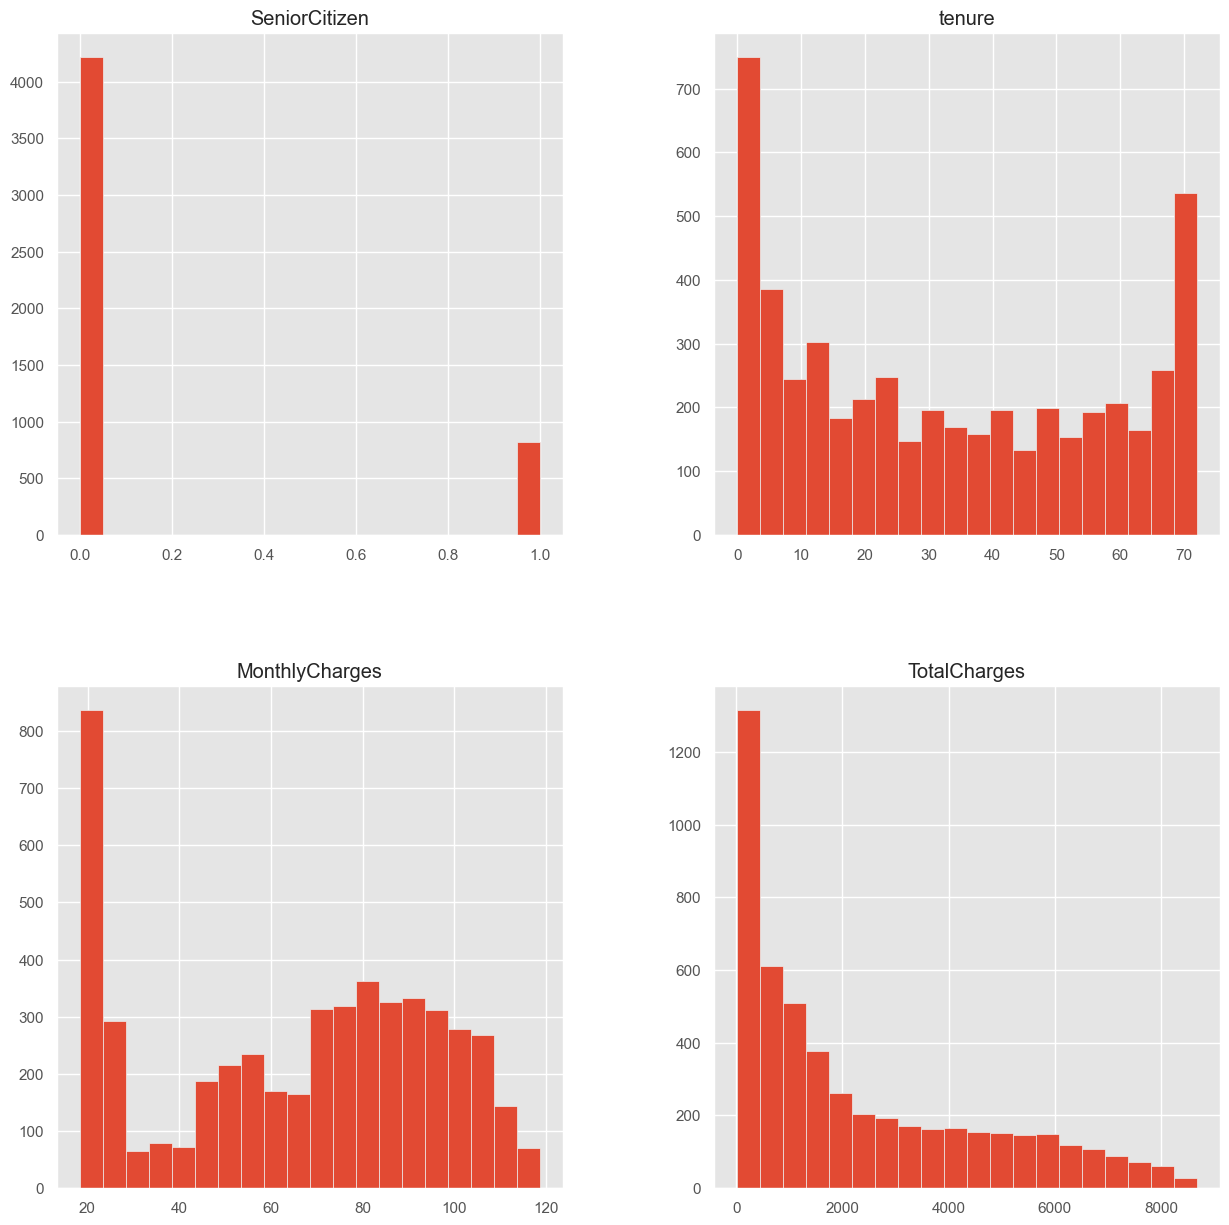

In [34]:
#  Display the numeric columns on a histogram 

numeric_columns = train.select_dtypes(include=[np.number]).columns
train[numeric_columns].hist(bins=20, figsize=(15, 15))
plt.show()


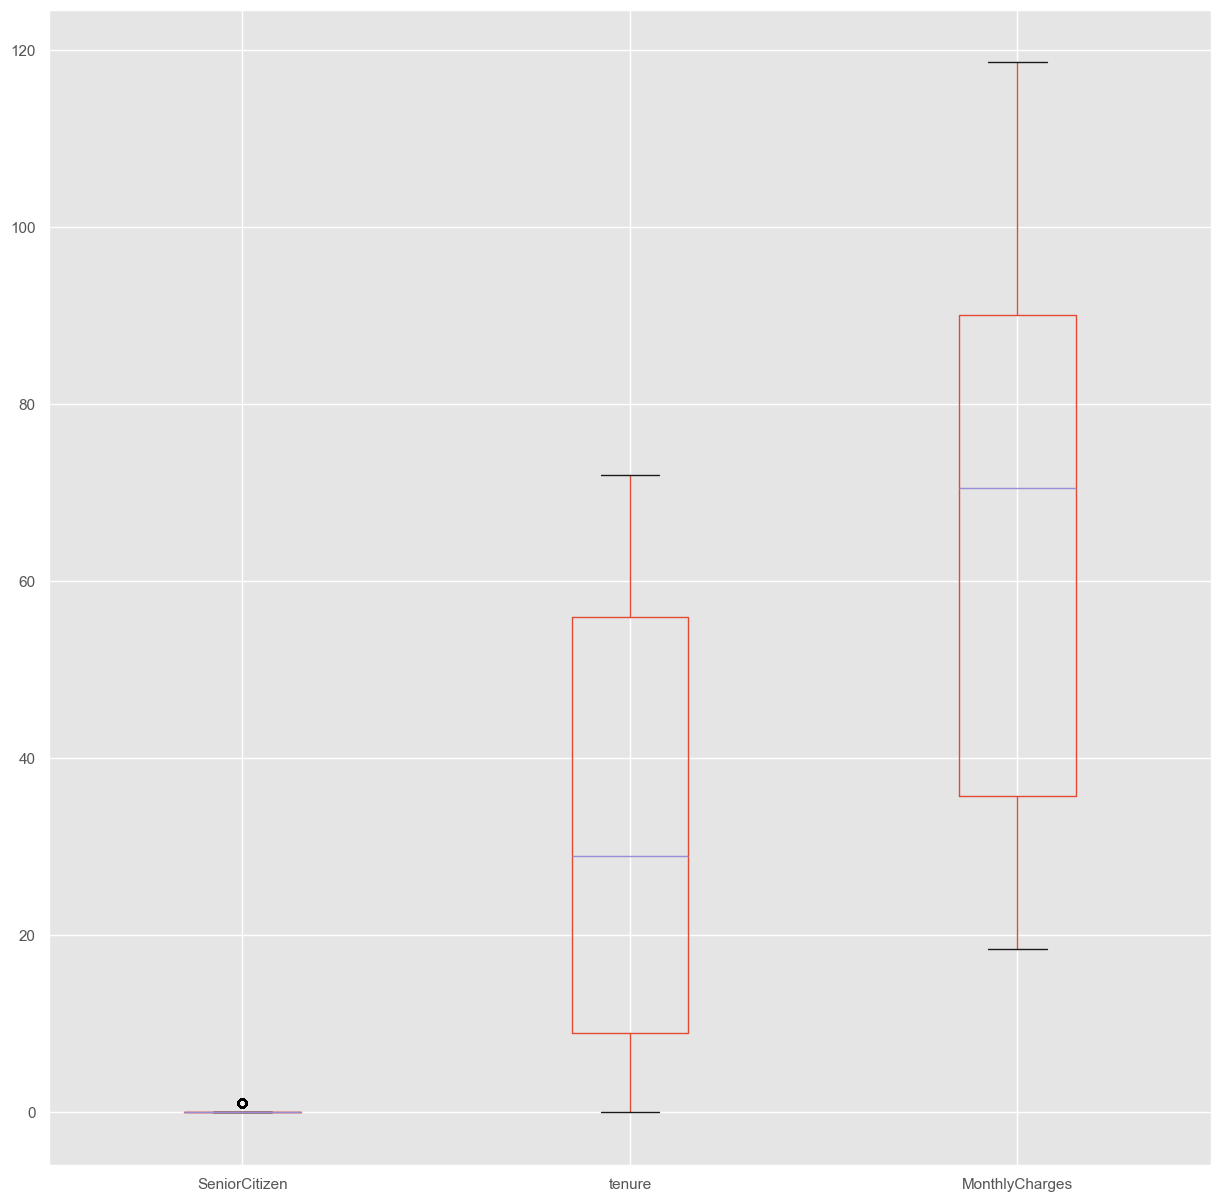

In [35]:
#  display bumeric columns on a boxplot except Total charges 

numeric_columns = train.select_dtypes(include=[np.number]).columns
numeric_columns = numeric_columns.drop('TotalCharges')
train[numeric_columns].boxplot(figsize=(15, 15))
plt.show()


In [36]:
# Display unique values in the data 

for column in train.columns:
    print(f"Unique values in '{column}': {train[column].unique()}")

Unique values in 'customerID': ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in 'gender': ['Female' 'Male']
Unique values in 'SeniorCitizen': [0 1]
Unique values in 'Partner': [True False 'No' 'Yes']
Unique values in 'Dependents': [False True 'No' 'Yes']
Unique values in 'tenure': [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Unique values in 'PhoneService': [False True 'Yes' 'No']
Unique values in 'MultipleLines': [False True 'No' 'No phone service' 'Yes']
Unique values in 'InternetService': ['DSL' 'Fiber optic' 'No']
Unique values in 'OnlineSecurity': [False True 'No' 'Yes' 'No internet service']
Unique values in 'OnlineBackup': [True False 'No' 'Yes' 'No internet service']
Unique values in 'DeviceProtection': [False True 'No' 'Yes' 'No internet service']
U